Download the package

In [1]:
!git clone https://github.com/Gr1Lo/direct.git

Cloning into 'direct'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 363 (delta 112), reused 101 (delta 55), pack-reused 156
Receiving objects: 100% (363/363), 8.14 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (164/164), done.


Import functions

In [ ]:
import shutil

shutil.rmtree('/content/direct/')

In [2]:
import sys
sys.path.insert(0,'/content/direct/scripts')
from utils import find_nearest, CE, RE, direct_statistics
from plots import plot3d, plot2d, plot_clim_train_test
from read_data import rwl2pandas, read_meteo, direct_read, standardize_train, standardize_test, train_test_split
from direct_surface import sq_method, make_surface, predict_on_surface, leave_k_out_plot

Read data

In [3]:
import pandas as pd
import numpy as np

#====================== meteo-data preparation=====================
clim_df = pd.read_csv('/content/direct/Kluhorskij Pereval/TG_STAID008552.txt',
                      skiprows=19)
clim_df.columns = clim_df.columns.str.replace(' ', '')

#filter by quality code
clim_df = clim_df[clim_df['Q_TG']!=9]

#find mean by months
clim_df['DATE'] = pd.to_datetime(clim_df['DATE'].astype(str), format='%Y%m%d')
clim_df = clim_df.groupby(pd.PeriodIndex(clim_df['DATE'], freq="M"))['TG'].mean()

df = pd.DataFrame(index=np.sort(np.unique(clim_df.index.year)),
                  columns=np.sort(np.unique(clim_df.index.month)))
for i, v in clim_df.items():
  df.at[i.year, i.month]=v

df.to_csv(path_or_buf='/content/direct/Kluhorskij Pereval/TG.txt', sep='\t',
          columns=None, header=False, index=True, na_rep='NaN')
#===========================================================================

#reading meteo and proxy data into single dataframe
proxy_name='BI'
clim_name = 'June–September mean temperature'
mres = direct_read('/content/direct/Kluhorskij Pereval/Cauc_BI_inv.rwl',
              '/content/direct/Kluhorskij Pereval/TG.txt',
              proxy_name=proxy_name,
              clim_name = clim_name,
              meteo_months=[5,6,7,8])

/content/direct/scripts/read_data.py:92: RuntimeWarning: divide by zero encountered in log
  all_l.append([year_line, ob, age_first, ind_file, np.log(ob), np.log(age_first)])


Find best parameters for surface

In [ ]:
#====================== meteo-data preparation=====================
clim_df = pd.read_csv('/content/direct/Kluhorskij Pereval/TG_STAID008552.txt',
                      skiprows=19)
clim_df.columns = clim_df.columns.str.replace(' ', '')

#filter by quality code
clim_df = clim_df[clim_df['Q_TG']!=9]

#find mean by months
clim_df['DATE'] = pd.to_datetime(clim_df['DATE'].astype(str), format='%Y%m%d')
clim_df = clim_df.groupby(pd.PeriodIndex(clim_df['DATE'], freq="M"))['TG'].mean()

df = pd.DataFrame(index=np.sort(np.unique(clim_df.index.year)),
                  columns=np.sort(np.unique(clim_df.index.month)))
for i, v in clim_df.items():
  df.at[i.year, i.month]=v

df.to_csv(path_or_buf='/content/direct/Kluhorskij Pereval/TG.txt', sep='\t',
          columns=None, header=False, index=True, na_rep='NaN')
#===========================================================================

#reading meteo and proxy data into single dataframe
proxy_name='BI'
clim_name = 'JJAS mean temperature'
mres = direct_read('/content/direct/Kluhorskij Pereval/Cauc_BI_inv.rwl',
              '/content/direct/Kluhorskij Pereval/TG.txt',
              proxy_name=proxy_name,
              clim_name = clim_name,
              meteo_months=[5,6,7,8])


#select series with D18 or D09S prefix
D18 = mres.loc[mres["file"].str.startswith(('D18'), na=False)]
D09S =mres.loc[mres["file"].str.startswith(('D09S'), na=False)]
D18_av = D18[[proxy_name,'years']].groupby('years').mean()
D09S_av = D09S[[proxy_name,'years']].groupby('years').mean()

#concat two dfs into one with mean adjustment
d = np.mean(D18_av[proxy_name][D18_av.index>=1951])-np.mean(
    D09S_av[proxy_name][D09S_av.index>=1951])

D09S[proxy_name][D09S['years']>1883] =D09S[proxy_name][D09S['years']>1883]+d
mres = pd.concat([D09S,D18])
mres = mres.drop(clim_name,axis=1)

#read df with instrumental data and existing reconsruction
clim_df_e = pd.read_csv('/content/direct/Kluhorskij Pereval/BI rec.csv')
clim_df_e.rename(columns={'year':'years'}, inplace=True)

#merge all dfs
mres = mres.merge(clim_df_e, left_on='years', right_on='years', how='left')
mres.rename(columns={'VI IX instr':clim_name}, inplace=True)


''' validation
#mask years for train and test dfs
ys =np.sort(np.unique(mres.years))
mask = ~(ys>=1981)# (ys>1981)
train, test, train_dict = train_test_split(mres, proxy_name,
                                           clim_name, years_mask=mask)
'''


since1800 = mres[mres['years']>=1800]
since1800 = since1800.drop(since1800[since1800.BI==0].index)
since1800 = since1800.drop(since1800[since1800.BI<100].index)#!!!!!!!!!!!!!!!!!!!!
ys =np.sort(np.unique(since1800.years))
mask = ~(ys>=1951)
train, test, train_dict = train_test_split(since1800, proxy_name,
                                           clim_name, years_mask=mask)
#create dataset for new reconsruction
since1800 = standardize_test(train_dict, since1800, proxy_name, clim_name, age_var='age')



  0%|          | 0/4 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:14,  7.27s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:32<00:17, 17.82s/it]

n squares: 50



 25%|██▌       | 1/4 [01:30<04:31, 90.61s/it]

smooth: 3



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:06<00:13,  6.71s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:31<00:17, 17.52s/it]

n squares: 50



 50%|█████     | 2/4 [02:58<02:58, 89.20s/it]

smooth: 5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:06<00:12,  6.41s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:31<00:17, 17.30s/it]

n squares: 50



 75%|███████▌  | 3/4 [04:25<01:27, 87.94s/it]

smooth: 10



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:15,  7.53s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:32<00:17, 17.58s/it]

n squares: 50



100%|██████████| 4/4 [05:54<00:00, 88.51s/it]


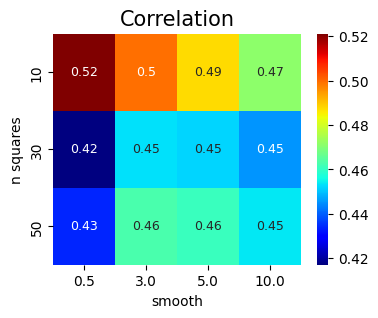

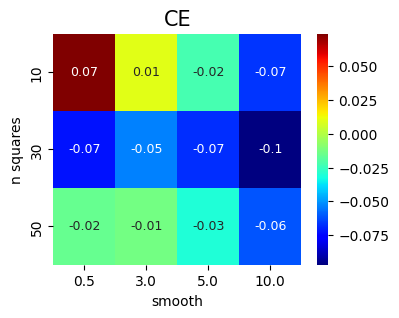

In [ ]:
metrics = leave_k_out_plot(train,clim_name, proxy_name,n_sq=[10,30,50],
                           sm=[0.5,3,5,10],
                           kernel='linear',k=14,
                           Z_shift=False)

  0%|          | 0/4 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:15,  7.93s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:35<00:19, 19.26s/it]

n squares: 50



 25%|██▌       | 1/4 [01:33<04:40, 93.66s/it]

smooth: 3



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:08<00:16,  8.10s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:34<00:19, 19.12s/it]

n squares: 50



 50%|█████     | 2/4 [03:08<03:08, 94.48s/it]

smooth: 5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:08<00:16,  8.21s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:35<00:19, 19.35s/it]

n squares: 50



 75%|███████▌  | 3/4 [04:43<01:34, 94.49s/it]

smooth: 10



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:15,  7.68s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:34<00:19, 19.06s/it]

n squares: 50



100%|██████████| 4/4 [06:18<00:00, 94.75s/it]


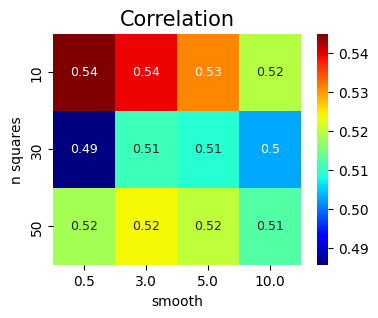

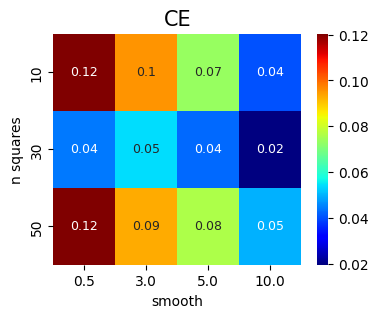

In [ ]:
metrics = leave_k_out_plot(train,clim_name, proxy_name,n_sq=[10,30,50],
                           sm=[0.5,3,5,10],
                           kernel='thin_plate_spline',k=14,
                           Z_shift=False)

  0%|          | 0/4 [00:00<?, ?it/s]

smooth: 0.5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:08<00:16,  8.09s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:36<00:20, 20.33s/it]

n squares: 50



 25%|██▌       | 1/4 [01:35<04:46, 95.58s/it]

smooth: 3



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:15,  7.97s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:34<00:19, 19.07s/it]

n squares: 50



 50%|█████     | 2/4 [03:09<03:08, 94.39s/it]

smooth: 5



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:14,  7.07s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:34<00:18, 18.91s/it]

n squares: 50



 75%|███████▌  | 3/4 [04:44<01:34, 94.69s/it]

smooth: 10



  0%|          | 0/3 [00:00<?, ?it/s]

n squares: 10



 33%|███▎      | 1/3 [00:07<00:14,  7.09s/it]

n squares: 30



 67%|██████▋   | 2/3 [00:33<00:18, 18.71s/it]

n squares: 50



100%|██████████| 4/4 [06:16<00:00, 94.22s/it]


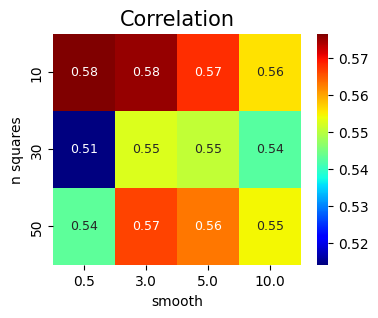

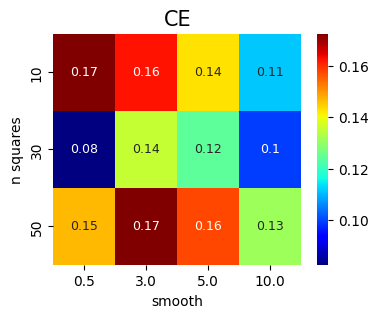

In [ ]:
metrics = leave_k_out_plot(train,clim_name, proxy_name,n_sq=[10,30,50],
                           sm=[0.5,3,5,10],
                           kernel='thin_plate_spline',k=14,
                           Z_shift=True)

Create surface

/content/direct/scripts/direct_surface.py:151: RuntimeWarning: invalid value encountered in cast
  cmap="jet", annot=np.int16(cou_Z),


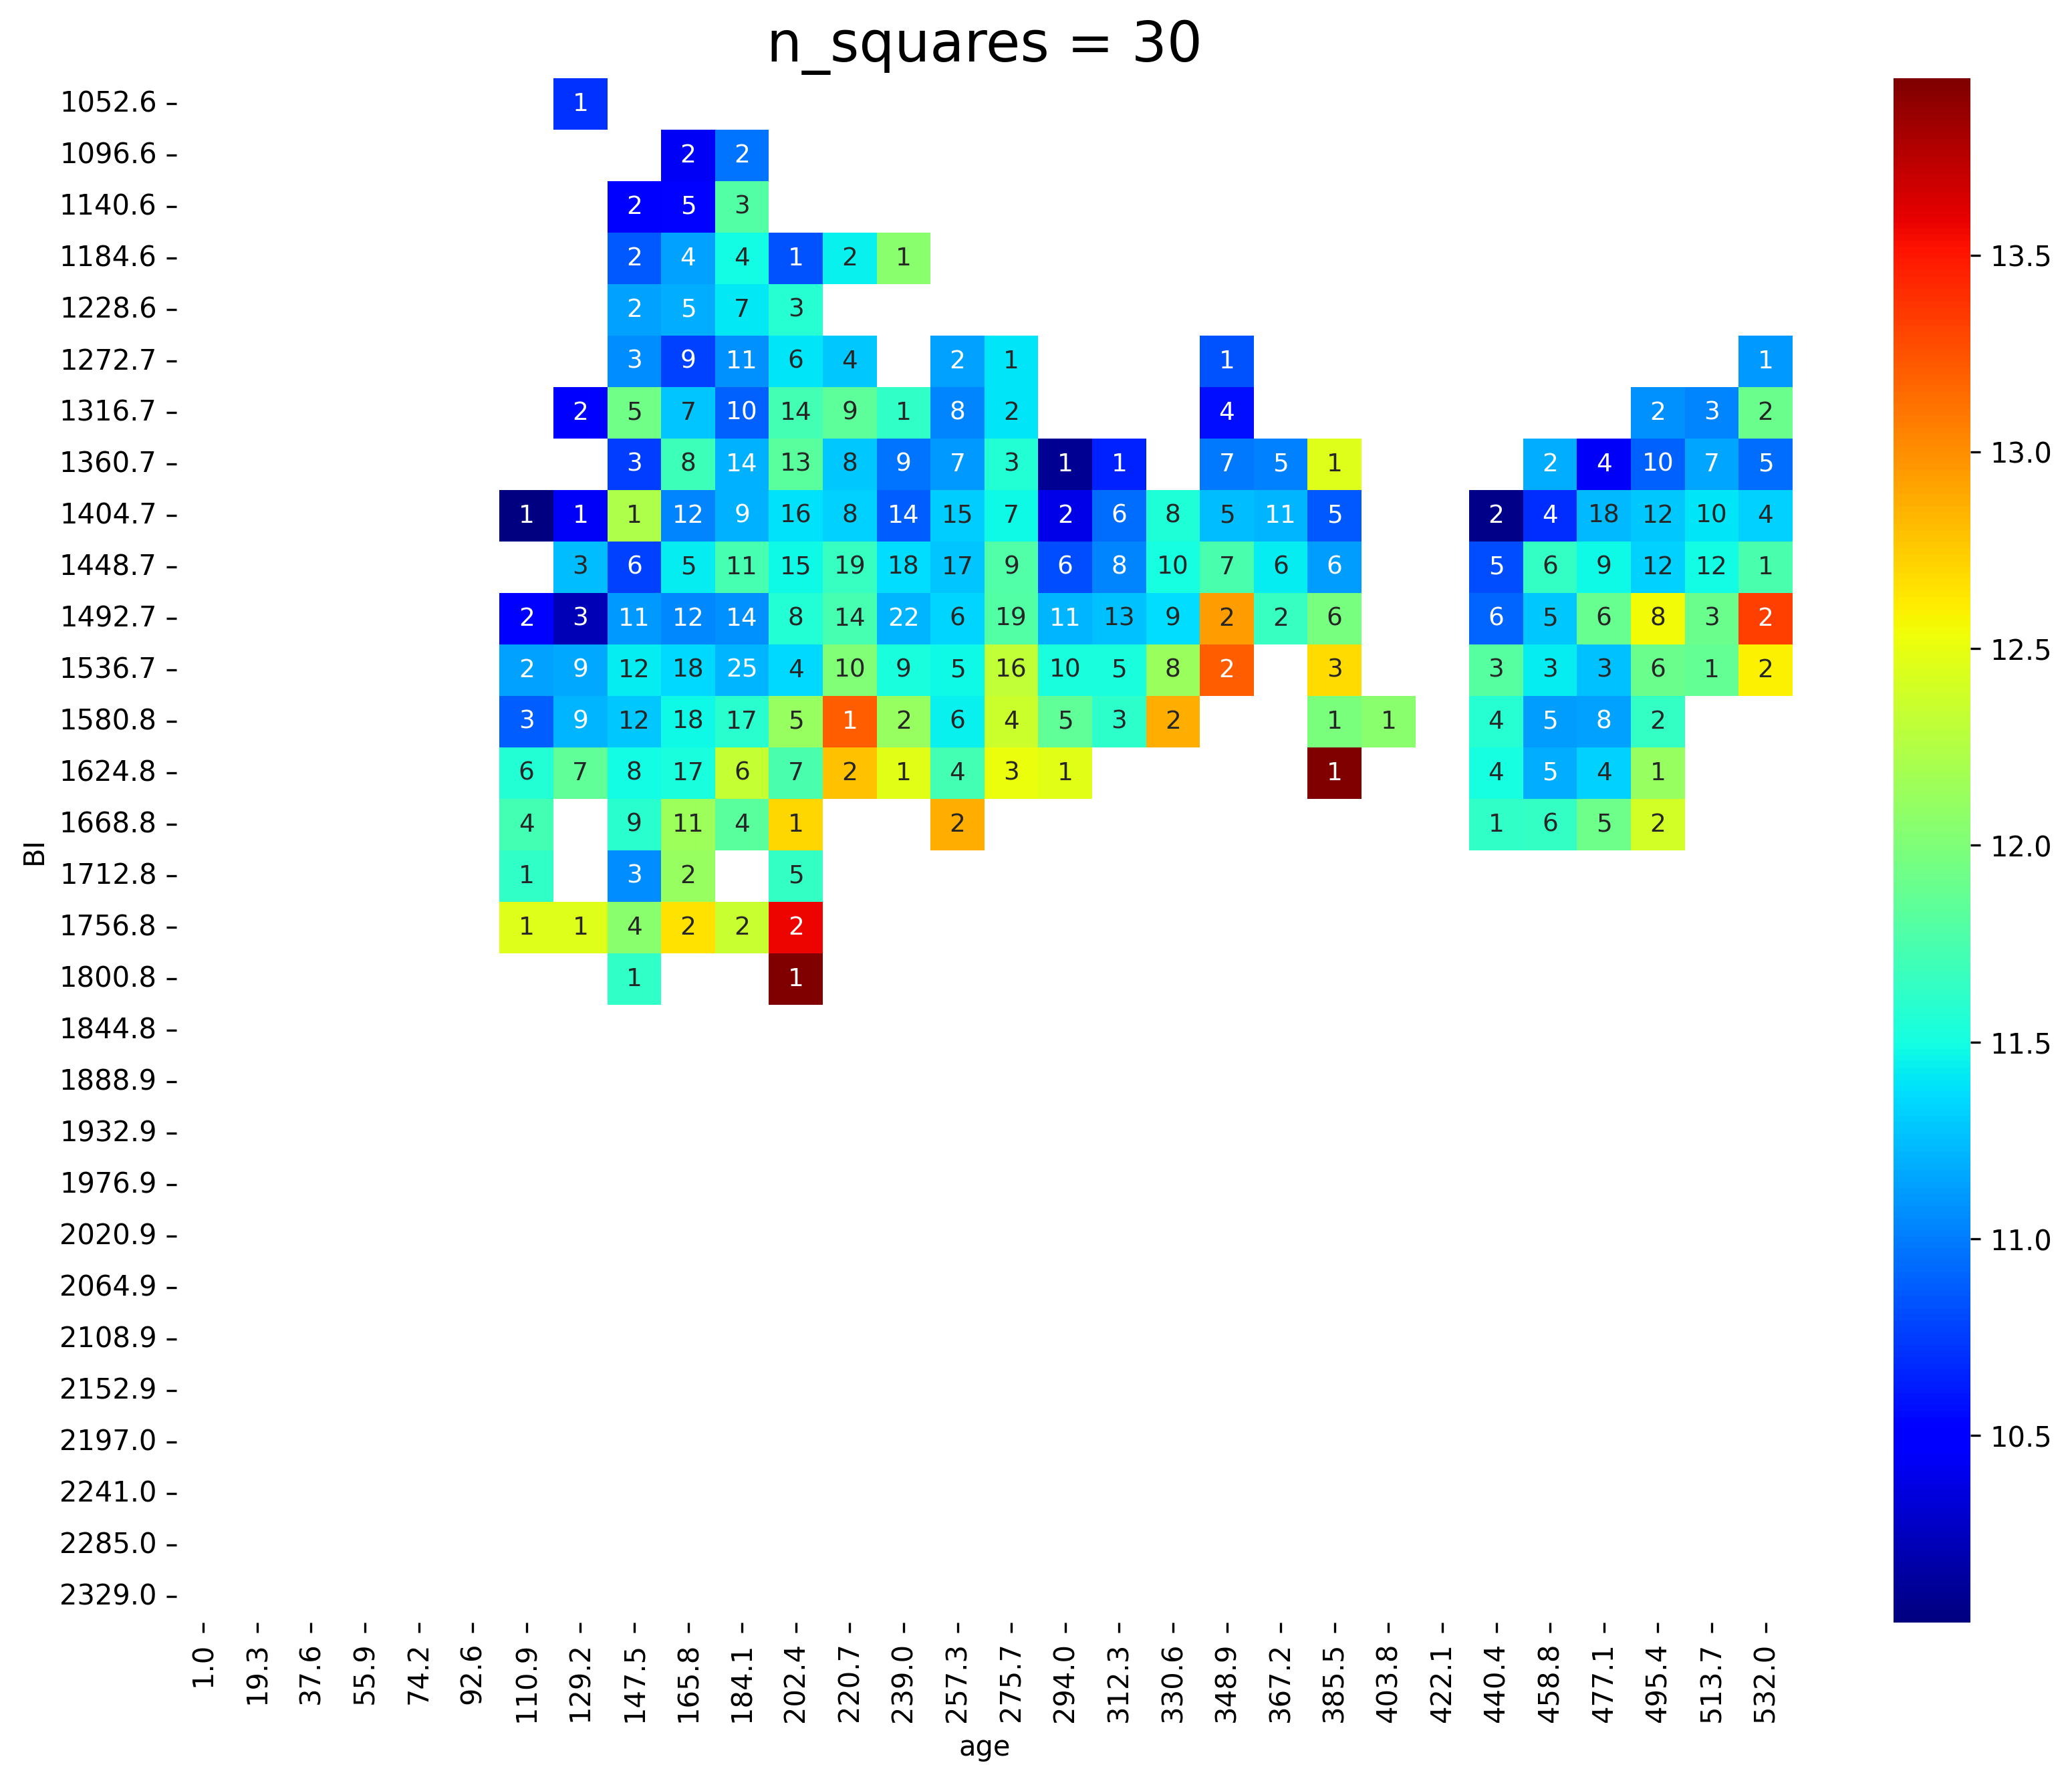

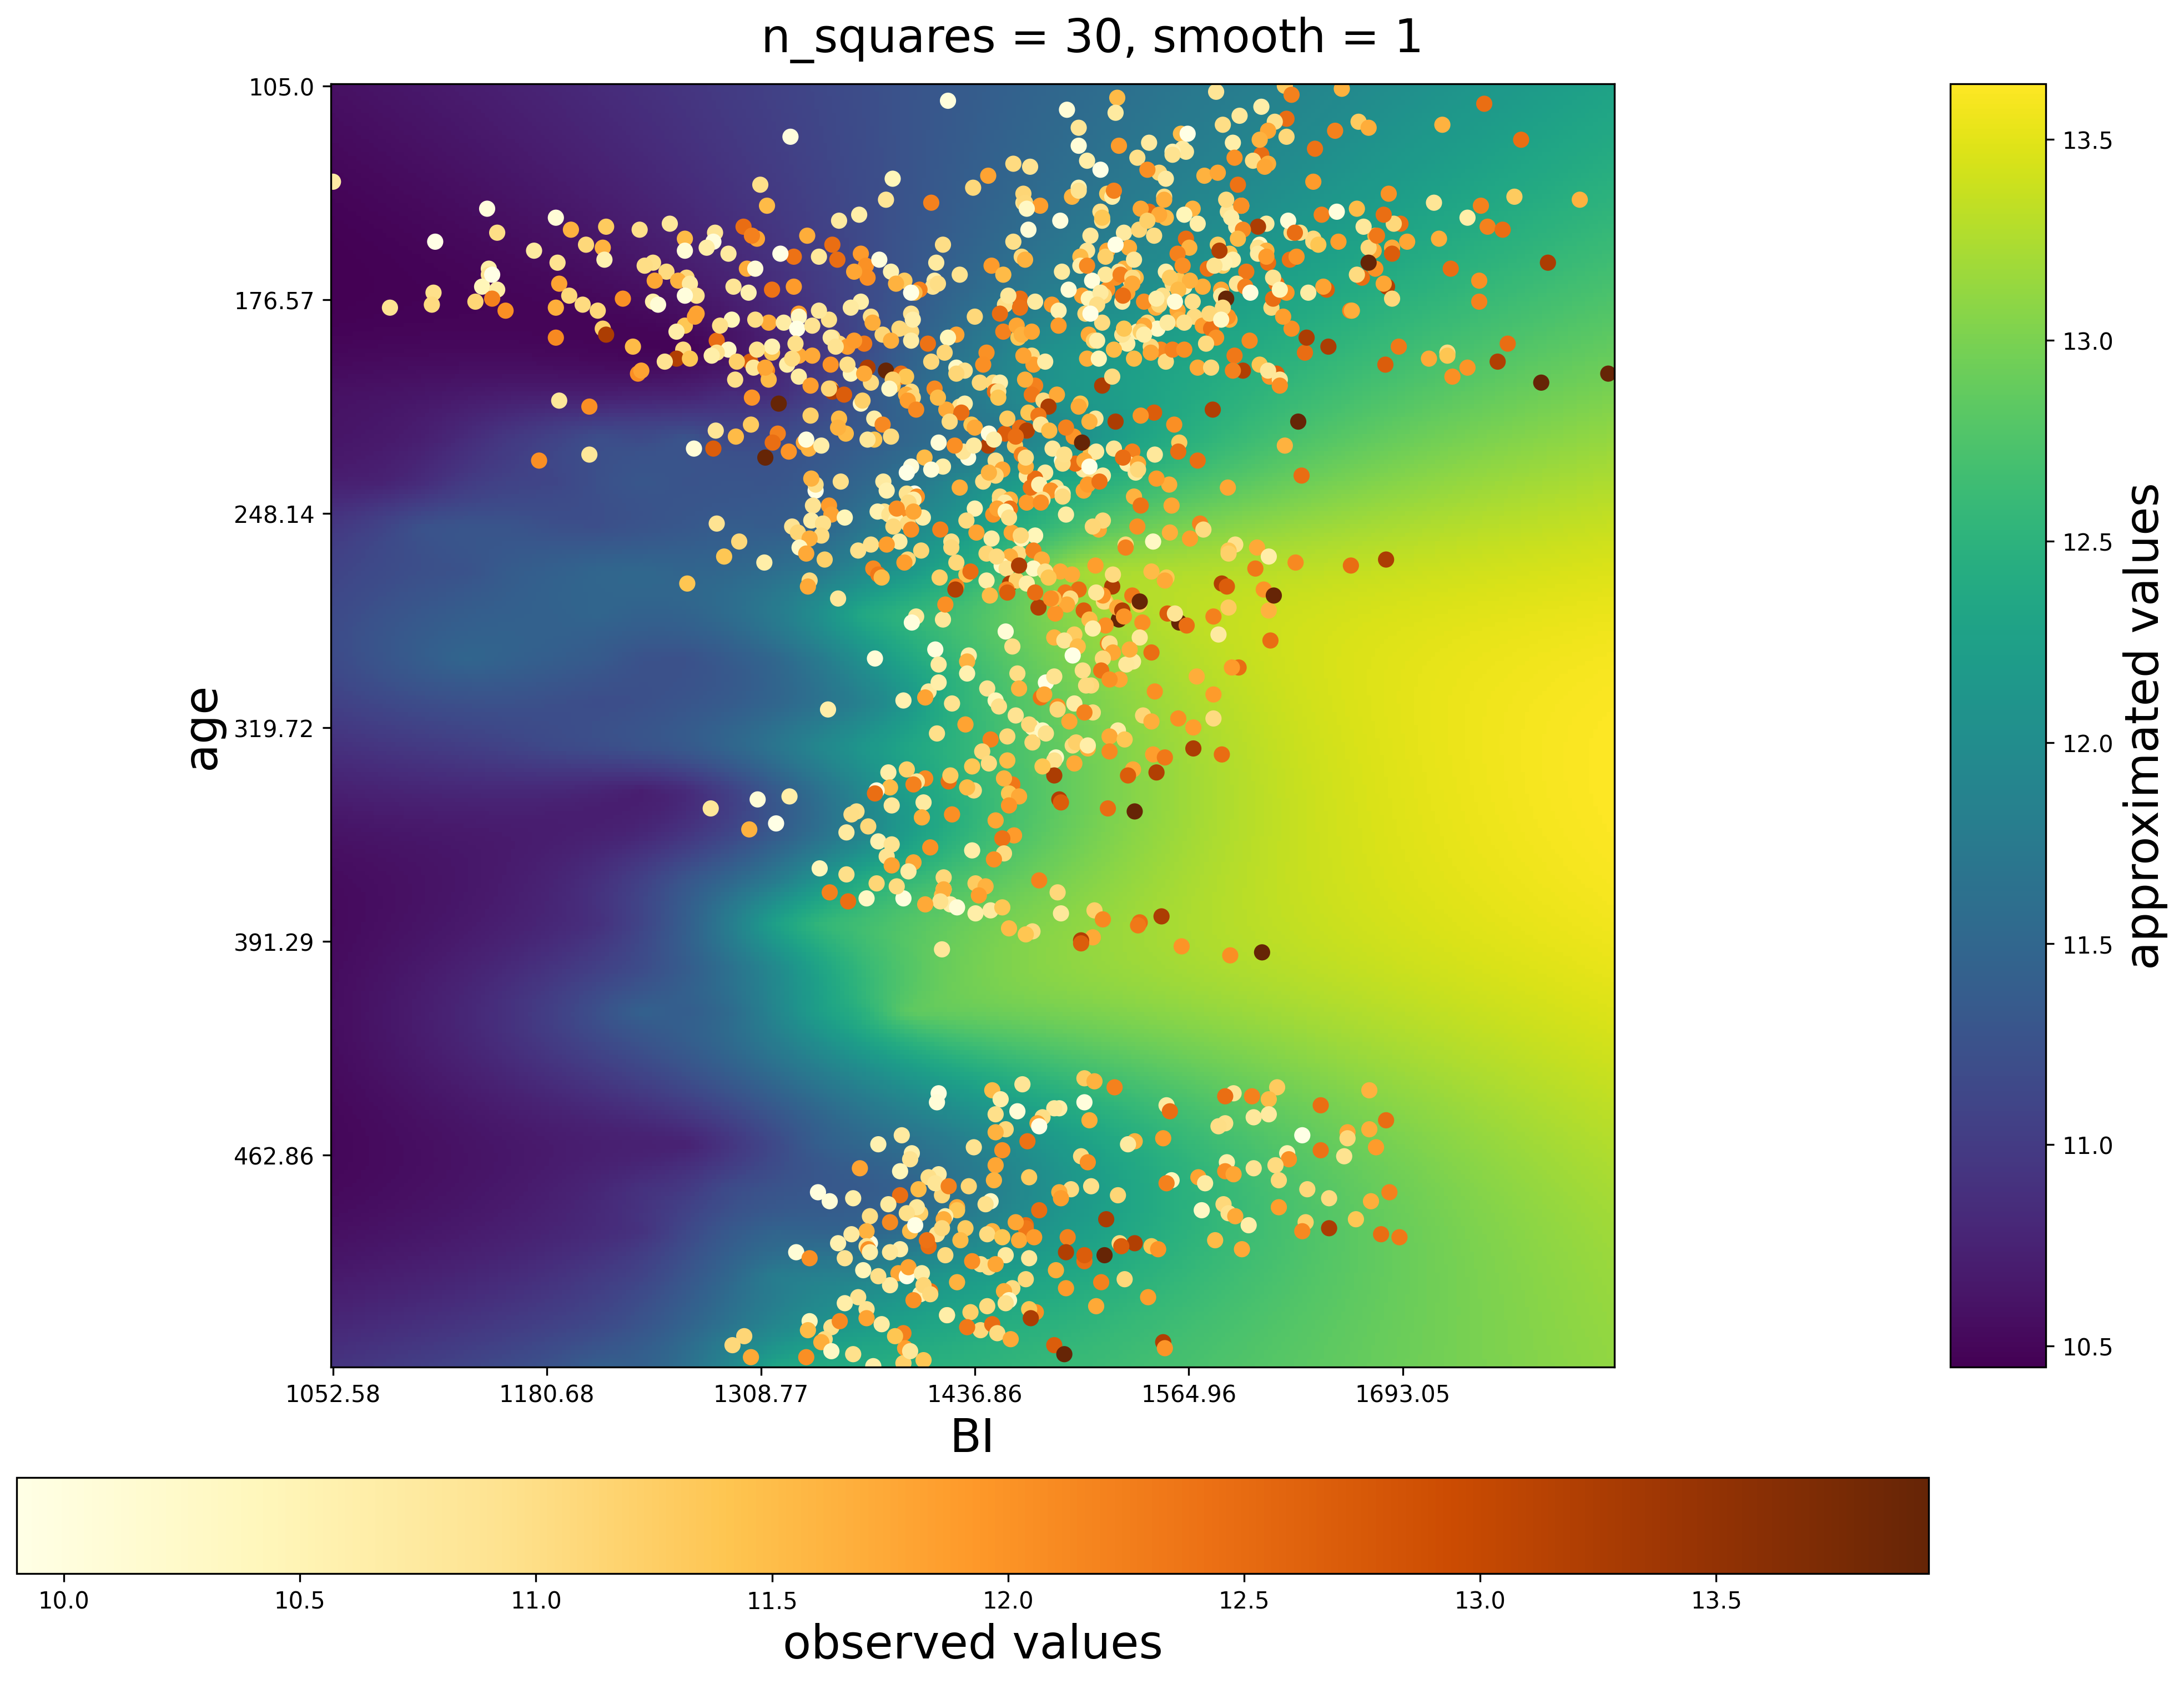

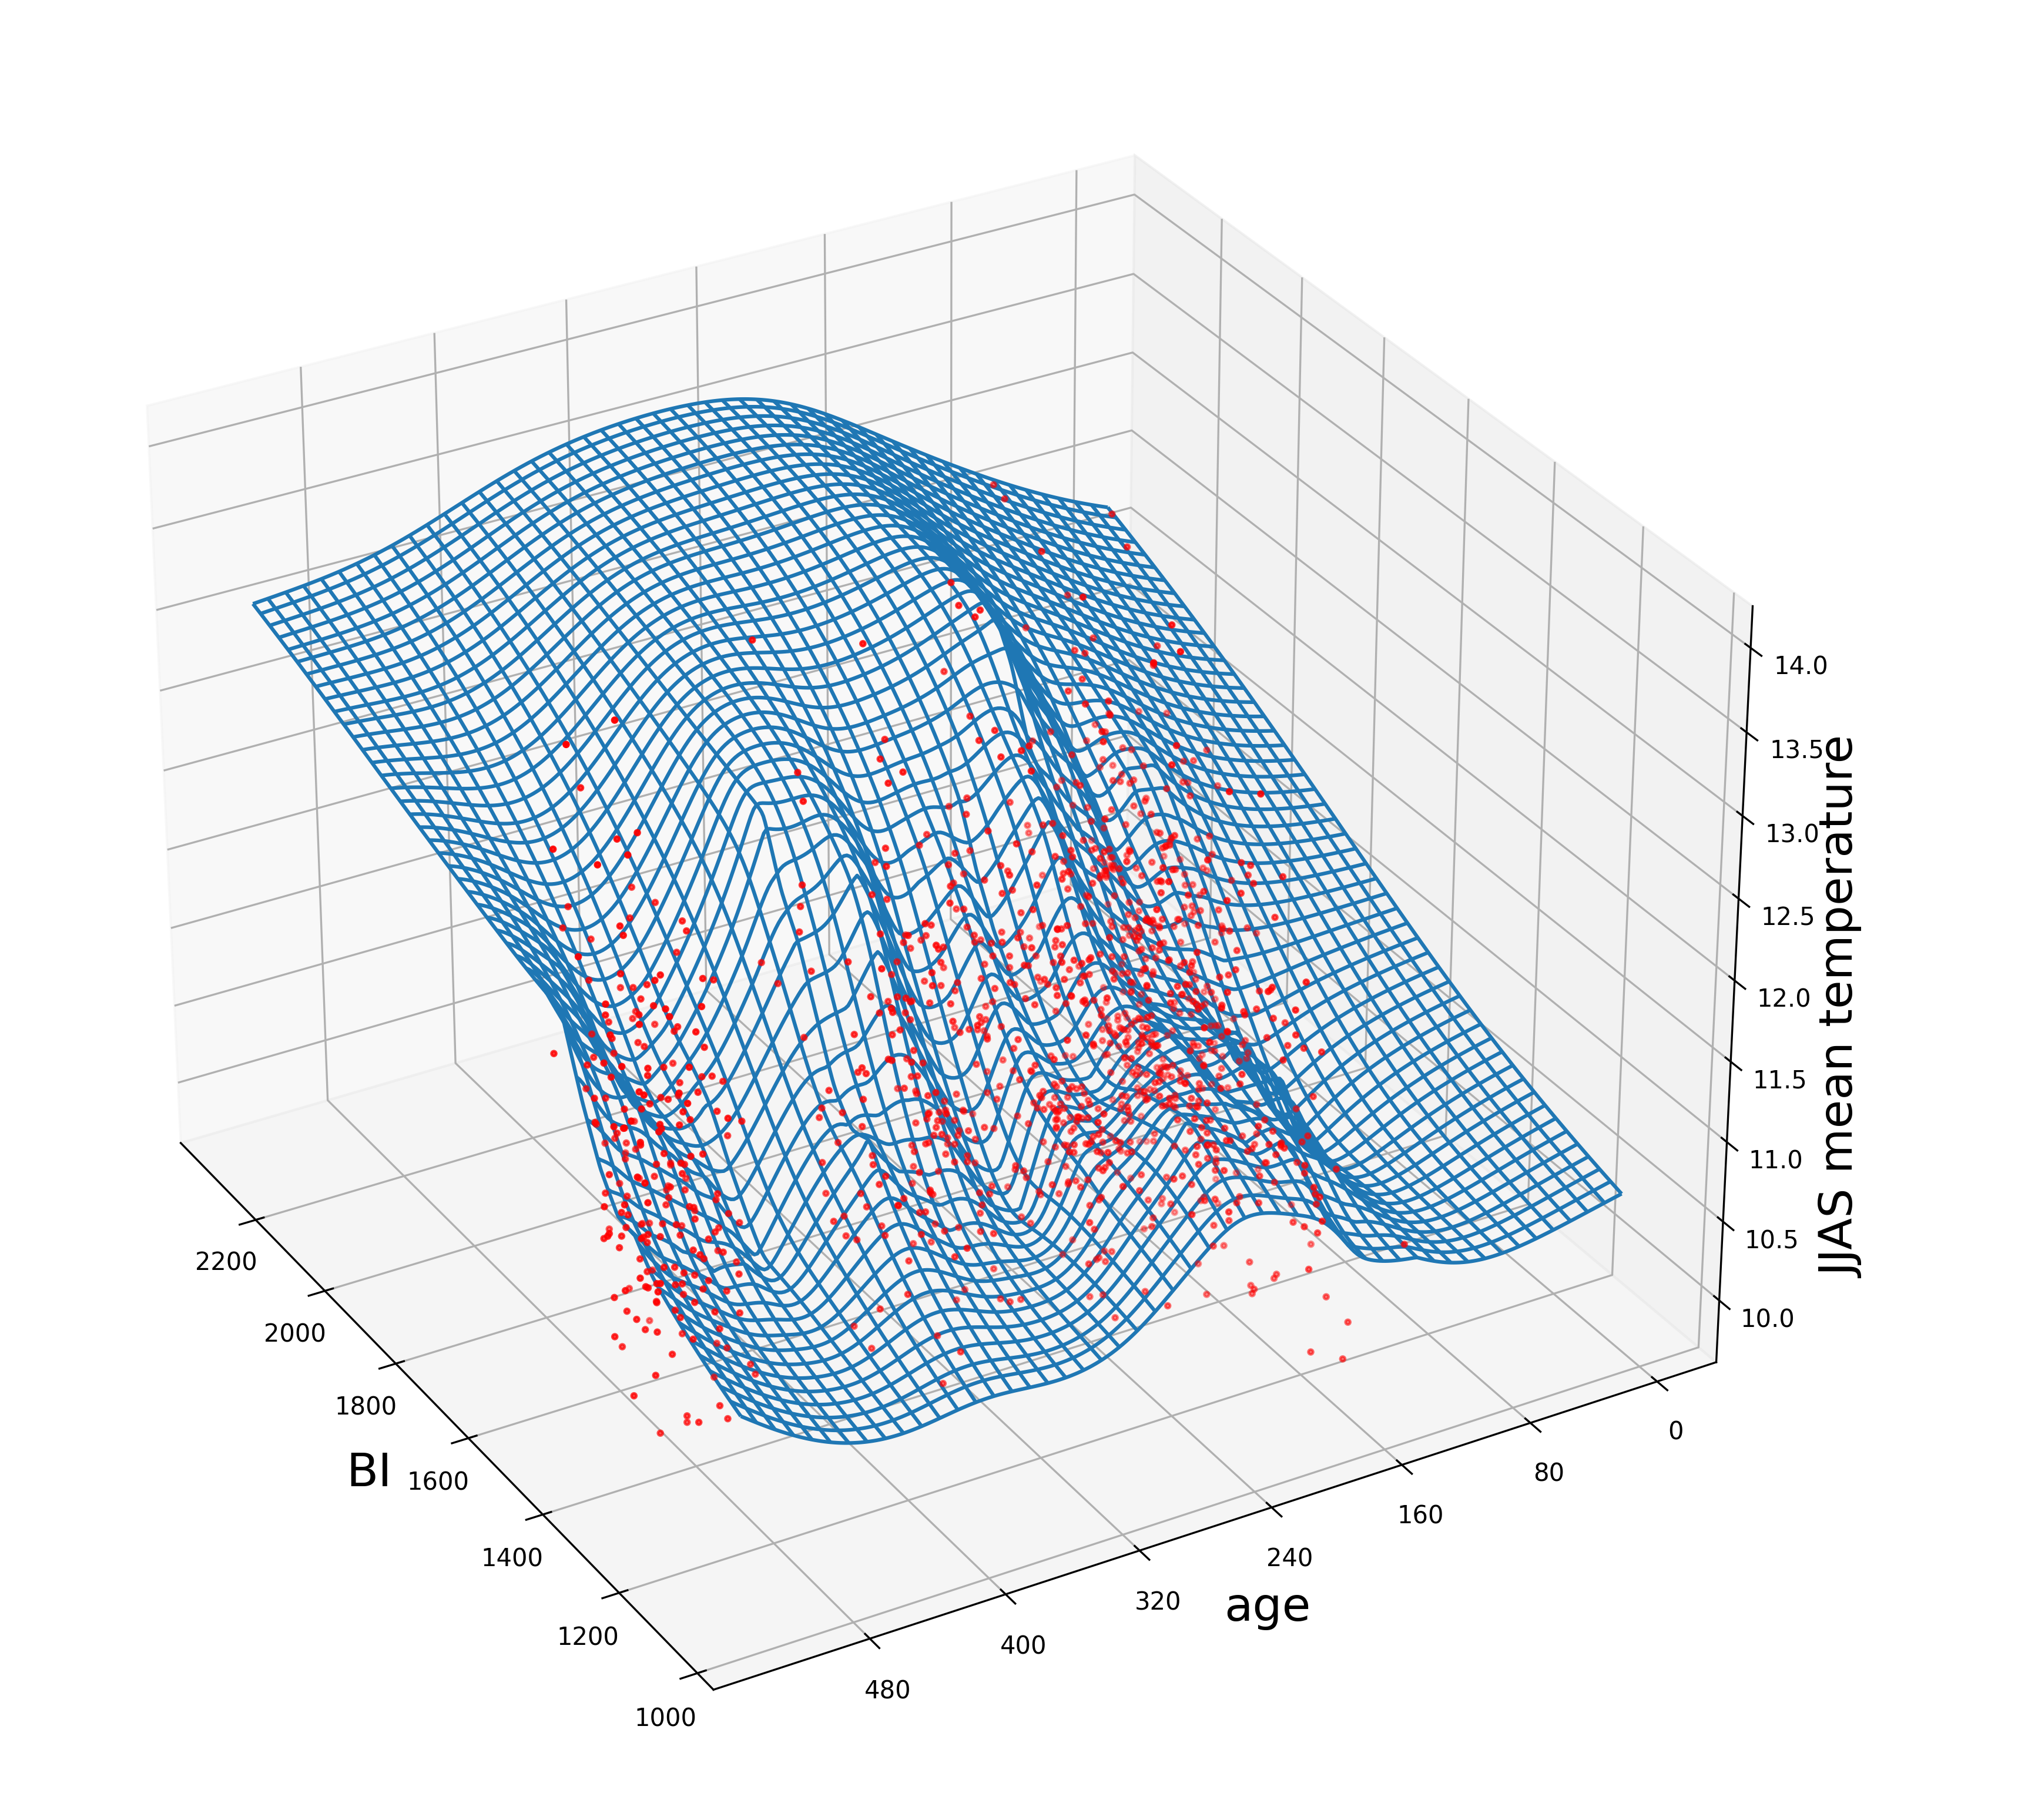

In [27]:
sm = 1 #smoothing parameter #0.5
n_sq = 30 #number of squares in axes for averaging
n = 300 #number of values in axes
uncertainty_data_rep = {
  "part_s": 0.5,
  "n_iter": 1000,
  "alpha":0.05
}
uncertainty_instrumental = {
  "part_s": 0.5,
  "n_iter": 500,
  "alpha":0.05,
  'kernel':'linear',
  'use_squares':True,
  'n' : 300,
  'n_sq' : 50,
  'sm' : 0.5
}



proxy_lim = [min(min(since1800[proxy_name]),min(since1800[proxy_name])),
             max(max(since1800[proxy_name]),max(since1800[proxy_name]))]
age_lim = [min(min(since1800['age']),min(since1800['age'])),
             max(max(since1800['age']),max(since1800['age']))]

surface = make_surface(train, train_dict, sm, n_sq, n,
                              proxy_lim = proxy_lim,
                              age_lim = age_lim,
                              kernel='linear',
                              proxy_name=proxy_name,
                              clim_var = clim_name,
                              use_squares=True)

#surface plots
nn = 'n_squares = ' + str(n_sq) + ', smooth = ' + str(sm)
plot2d(train, surface, name_ = nn, proxy_name=proxy_name, clim_name=clim_name)
plot3d(train, surface, proxy_lim, age_lim, name_ = '', proxy_name=proxy_name, clim_name=clim_name)

#make new prediction
pred_df = predict_on_surface(surface, train_dict, train, since1800,
           use_std=True, proxy_lim = proxy_lim, age_lim = age_lim,
           proxy_name=proxy_name,
           clim_var = clim_name,
           uncertainty_data_rep = None,
           uncertainty_instrumental = None,
            Z_shift=True)

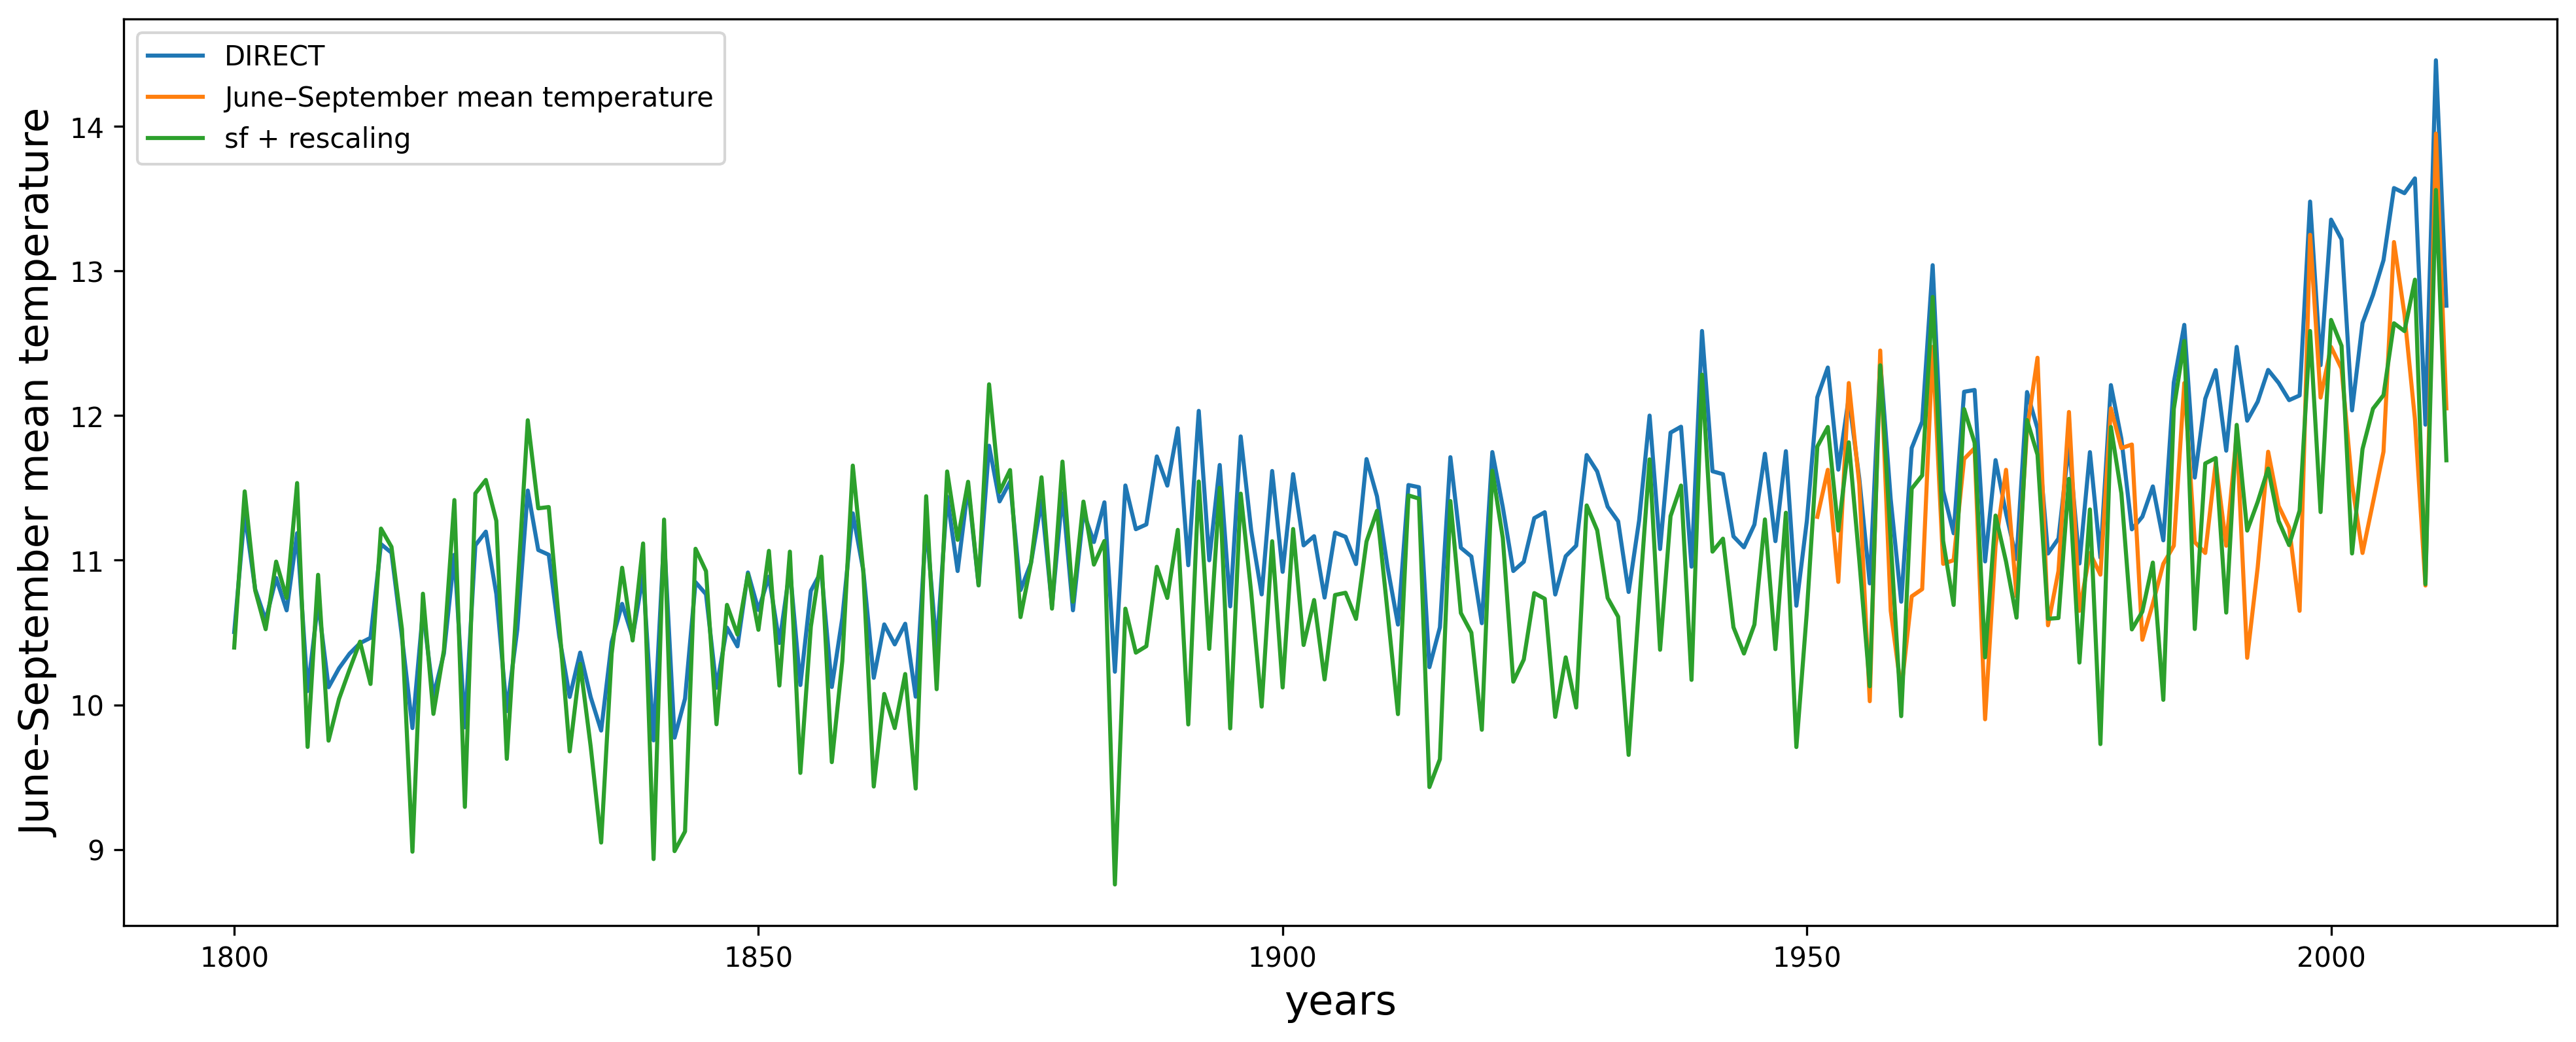

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

plt.plot(pred_df.index.values, pred_df['preds'].values, label = "DIRECT")
plt.plot(pred_df.index.values, pred_df['JJAS mean temperature'].values, label = "June–September mean temperature")
plt.plot(pred_df.index.values, pred_df['sfc_resc'].values, label = "sf + rescaling")
#plt.plot(pred_df.index.values, pred_df['lower_2'].values, c='gray',lw=1,linestyle='dashed',label = "quntile(0.025)")
#plt.plot(pred_df.index.values, pred_df['upper_2'].values, c='gray',lw=1,linestyle='dashed', label = "quntile(0.975)")
plt.ylabel('June-September mean temperature',fontsize=15)
plt.xlabel('years',fontsize=15)
plt.legend()

In [32]:
pred_df[['sfc_resc','preds','BI','JJAS mean temperature']].to_csv('/content/direct/Kluhorskij Pereval/Kluhorskij Pereval.csv')